# Automatic SDS-PAGE Gel Annotation with Python

This is an attempt at binderizing [this illustrative and awesome tweet and code](https://twitter.com/Steve_Harborne/status/1133064277445627904).

**The way the plotly plots get stored, you'll need to run all the cells first to see the last two plots rendered as output.**

----

Load the necessary modules.

In [1]:
import numpy as np
from scipy import signal
import peakutils
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.io as pio

## Demonstrate loading raw data

Edit the file name below to point at your data. 

In [2]:
gel_file = "screen_grab_of_demo_gel.png"

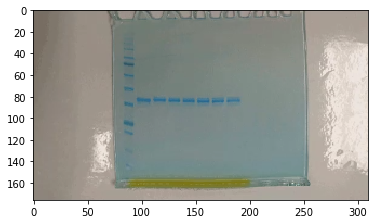

In [3]:
#%% Example of how it works

image = cv2.imread(gel_file)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Either specify here or specifiy when the function is called
gel_lanes=12

#Edit the markers to your own ones!
markers=['200','140','136','110','87','62','51','40','30','22','16']
lane_labels=['Lane'+str(x) for x in range(1,gel_lanes+1)]

#Show the image that has been loaded - WARNING - needs to be in the correct orientation for it work!
plt.imshow(image, cmap='gray');

## Demonstrating the masking to find the gel

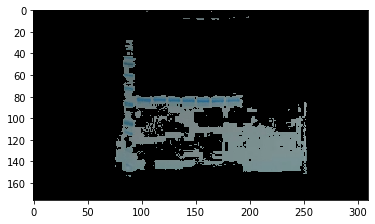

In [4]:
# The image must be converted to hsv for the filtering to work
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# define range of blue color in HSV
lower_blue = np.array([90,0,90])
upper_blue = np.array([230,255,255])

mask = cv2.inRange(hsv, lower_blue, upper_blue)
#np.argwhere(mask)

# View the mask to check it has done the correct job, otherwise the filters might need to be changed
res = cv2.bitwise_and(image,image, mask= mask)
plt.imshow(res, cmap='gray');

## Demonstrating cropping to the gel

Uses the mask method of detecting the gel to then crop to the gel.

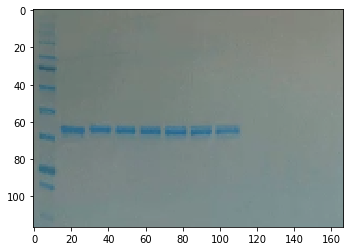

In [5]:
def crop_to_colour(image):
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_blue = np.array([90,0,90])
    upper_blue = np.array([230,255,255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    coords = np.argwhere(mask)
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    x_20=int((x_max-x_min)*0.12)
    y_20=int((y_max-y_min)*0.03)
    cropped = image[x_min+x_20:x_max-x_20, y_min+y_20:y_max-y_20]
    return cropped

cropped=crop_to_colour(image)
plt.imshow(cropped, cmap='gray');

## Demonstrate Detecting the Marker Postions

Edit the markers to match yours.

As written, the marker needs to be in the first lane.

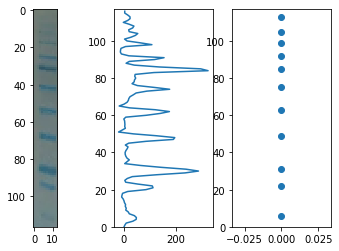

In [6]:
#Edit the markers to your own ones!
markers=['200','140','136','110','87','62','51','40','30','22','16']
lane_labels=['Lane'+str(x) for x in range(1,gel_lanes+1)]



def flatten_for_plot(data, axis):
    single=[]
    for y in data:
        single.append(np.sum(y)/3)
        
    single=np.array(single)  
    return single

first_lane=cropped[0:len(cropped),0:int(len(cropped[0])/gel_lanes)]

# Sum all of the darkest coloured pixels in the first lane 
first_lane_flat=flatten_for_plot(first_lane, 1)

# Needs to be inversed to make the numbers positive
inverse = [1-x for x in first_lane_flat]

# Neat little tool for estimating the baseline
base = peakutils.baseline(np.array(inverse))

# Neat little tool for finding peaks - these are the markers!
peaks = signal.find_peaks(inverse-base, prominence=20.2)
#print(len(peaks[0]))
#print(len(markers))
assert len(peaks[0]) == len(markers), ("Signal peak in marker lane doesn't "
    "match number of markers.\n{} signal peaks detected in marker lane. {} "
    "marker bands expected.\nAdjust prominence setting appropriately.".format(
    len(peaks[0]),len(markers)))
        
#View the result of marker selection using matplotlib

plt.subplot(1,3,1)
plt.imshow(first_lane, cmap='gray')
plt.subplot(1,3,2)
plt.ylim((0,len(inverse)))
plt.plot(list(reversed(inverse-base)), range(0,len(inverse)), marker=None, linestyle='-')
plt.subplot(1,3,3)
plt.ylim((0,len(inverse)))
plt.scatter([0]*len(peaks[0]),[np.max(len(inverse))-x for x in peaks[0]])
plt.show();

## Demonstrate annotating the gel

**The way the plotly plots get stored, you'll need to run the next two cells first to see the plots rendered as output.**

You may need to scroll to the right to see all the plot.


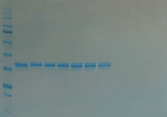

In [7]:
init_notebook_mode(connected=True)
def plotly_gel_output(image,marker_text,marker_positions,lanes):
    
    pil_img = Image.fromarray(image)
    
    img_width = len(image[0])
    img_height = len(image)
    abs_width = 900
    scale_factor = abs_width/img_width
    
    first_lane_pos=int((img_width*scale_factor/lanes)/2)
    last_lane_pos=int((img_width*scale_factor)-((img_width*scale_factor/gel_lanes)/2))
    intervals=int((last_lane_pos-first_lane_pos)/(lanes-1))
    
    

    layout= go.Layout(
            width = img_width*scale_factor,
            height = img_height*scale_factor,
            showlegend=True,
            xaxis = go.layout.XAxis(
                    visible = True,
                    range = [0, img_width*scale_factor],
                    showgrid = False, 
                    title='',
                    mirror='all',
                    side='top',
                    ticks='outside',
                    tick0=0,
                    dtick=100,
                    ticklen=8,
                    tickwidth=4,
                    tickcolor='#000',
                    linewidth=4,
                    linecolor='#000',
                    tickmode = 'array',
                    tickvals = [x for x in range(first_lane_pos,last_lane_pos,intervals)],
                    ticktext = list(range(1,lanes+1))), 
            yaxis = go.layout.YAxis(
                    visible=True,
                    range = [0, img_height*scale_factor],
                    showgrid = False, 
                    title='(kDa)',
                    mirror='all',
                    ticks='outside',
                    tick0=0,
                    dtick=100,
                    ticklen=8,
                    tickwidth=4,
                    tickcolor='#000',
                    linewidth=4,
                    linecolor='#000',
                    tickmode = 'array',
                    tickvals = [(img_height*scale_factor)-(x*scale_factor) for x in marker_positions],
                    ticktext = marker_text,),
                    # the scaleanchor attribute ensures that the aspect ratio stays constant
                    # scaleanchor = 'x'),
            font=dict(color='rgb(0,0,0)',size=24),
            margin=go.layout.Margin(
                        l=100,
                        r=50,
                        b=100,
                        t=100,
                        pad=0
                        ),
            images= [dict(
                  source= pil_img,
                  xref= "x",
                  yref= "y",
                  x= 0,
                  y= img_height*scale_factor,
                  sizex= img_width*scale_factor,
                  sizey= img_height*scale_factor,
                  sizing= "stretch",
                  opacity= 1,
                  layer= "below")])

    traces=[]
    for x in range(1,gel_lanes+1):
        trace= go.Scatter(
                    name=str(x)+': Lane '+str(x),
                    x=[0, img_width*scale_factor],
                    y=[0, img_height*scale_factor],
                    mode='markers',
                    marker={'color': '#000',
                            'opacity' : 0})
        traces.append(trace)
        
    fig = go.Figure(data=traces,layout=layout)
    
    
#    fig = go.Figure(data=[{
#            'x': [0, img_width*scale_factor], 
#            'y': [0, img_height*scale_factor], 
#                'mode': 'markers',
#                'marker': {'opacity': 1}}],layout = layout)
    
    iplot(fig, filename='gel_test.html')
    pio.write_image(fig, 'gel_test.png')
    
def plot_gel_image(input_gel,gel_lanes=12,markers=['200','140','136','110','87','62','51','40','30','22','16']):
    
    image = cv2.imread(input_gel)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #gel_lanes=12
    #markers=['200','140','136','110','87','62','51','40','30','22','16']
    #lane_labels=['Lane'+str(x) for x in range(1,gel_lanes+1)]

    cropped=crop_to_colour(image)    
    first_lane=cropped[0:len(cropped),0:int(len(cropped[0])/gel_lanes)]
    first_lane_flat=flatten_for_plot(first_lane, 1)
    inverse = [1-x for x in flat] 
    base = peakutils.baseline(np.array(inverse))
    peaks = signal.find_peaks(inverse-base, prominence=20.2)

    plotly_gel_output(cropped,markers,peaks[0],gel_lanes)
  
    
def get_layout():
    layout = go.Layout(
                    autosize = False, 
                    showlegend=True, 
                    legend=dict(
                            traceorder='normal',
                            font=dict(
                                    size=18,
                                    color='#000')),
                    height = 600,  
                    width = 900, 
                    yaxis = dict(showgrid = False, 
                                 tickmode='linear',
                                 title='Pixel Density',
                                 mirror=True,
                                 #range=[0,32],
                                 ticks='outside',
                                 tick0=0,
                                 dtick=1000,
                                 ticklen=8,
                                 tickwidth=2,
                                 tickcolor='#000',
                                 linewidth=4,
                                 linecolor='#000',), 
                    font=dict(color='rgb(0,0,0)',size=24),
                    xaxis = dict(
                            #zeroline = True,
                            showgrid = False,
                            #range=[0,2.4],
                            tickmode='linear',
                            tickangle=45,
                            mirror=True,
                            title='Gel Migration',
                            ticks='outside',
                            tick0=0,
                            dtick=100,
                            ticklen=8,
                            tickwidth=2,
                            tickcolor='#000',
                            linewidth=4,
                            linecolor='#000',
                            ),
                    margin=go.layout.Margin(
                        l=100,
                        r=50,
                        b=100,
                        t=100,
                        pad=0
                        ),
                    )
    return layout

def plotly_plot_lanes(image,gel_lanes=12):
    
    lane_length=int(len(image[0])/gel_lanes)
    
    traces=[]
    lane=1
    for x in range(0,lane_length*gel_lanes,lane_length):
        flat=flatten_for_plot(image[0:len(image),x:x+lane_length], 1) 
        inverse = [1-x for x in flat]
        base= peakutils.baseline(np.array(inverse))
        trace= go.Scatter(
                    name=str(lane)+': Lane '+str(lane),
                    x=list(range(0,len(inverse))),
                    y=inverse-base,
                    mode='lines',)
        traces.append(trace)
        lane=lane+1
    fig = go.Figure(data=traces, layout=get_layout())
    iplot(fig, filename='gel_lanes.html')
    pio.write_image(fig, 'gel_lanes.png')
    

#Plot the cropped image using plotly to make it look nice
plotly_gel_output(cropped,markers,peaks[0],gel_lanes);

## Demonstrating Plotting the Bands in the Lanes

You may need to scroll to the right to see all the plot.

In [8]:
init_notebook_mode(connected=True)
#Plot the gel lanes using plotly to make it look nice
plotly_plot_lanes(cropped,gel_lanes=12);

## Displaying the non-interactive versions of those plots

Those last two cells make interactive plots. At the same time they make non-interactive, **static images suitable for use elsewhere**, such as in a lab notebook.

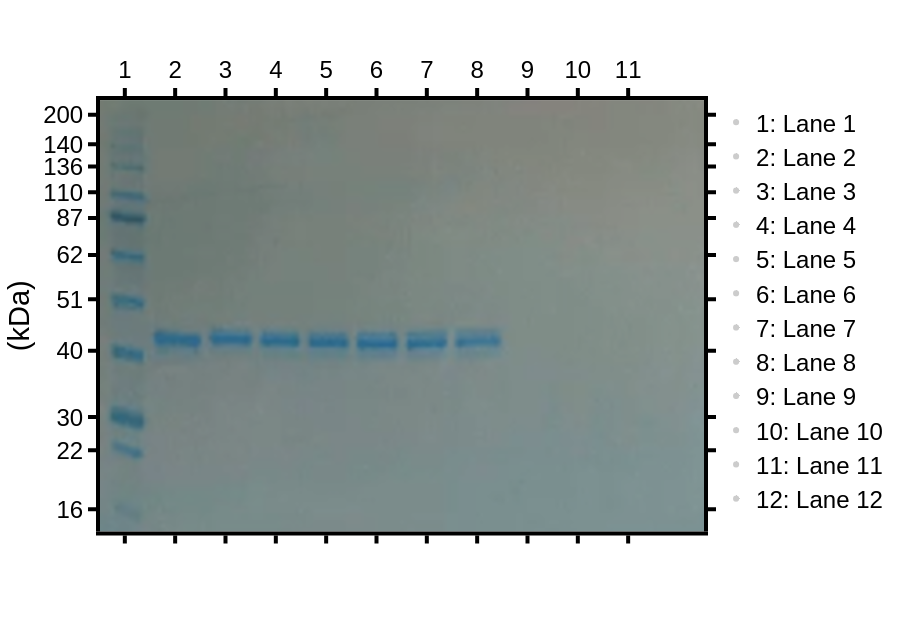

In [9]:
from IPython.display import Image
Image("gel_test.png")

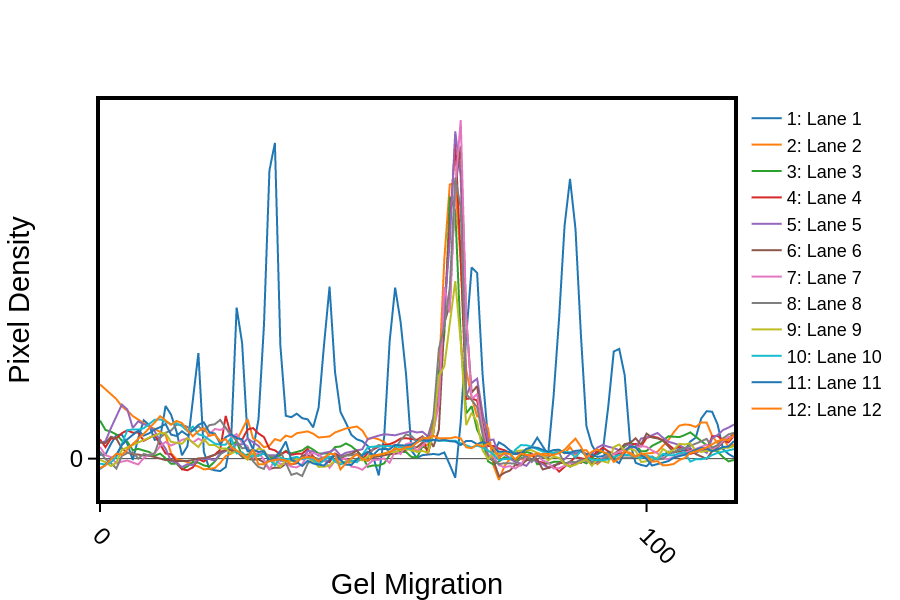

In [10]:
from IPython.display import Image
Image("gel_lanes.png")

Download those images if you have converted this to use your own data.

In the standard notebook interface, you can access the file directory with an interface for downloading the files by clicking on the Jupyter logo in the upper left corner of this window, just above the notebook `file` menu. From the file browser then you can selest the image files and download them.

-----

----